Iteration 1/500 - Max error: 367.39337158203125
Iteration 2/500 - Max error: 378.10797119140625
Iteration 3/500 - Max error: 378.10797119140625
Convergence reached at iteration 3


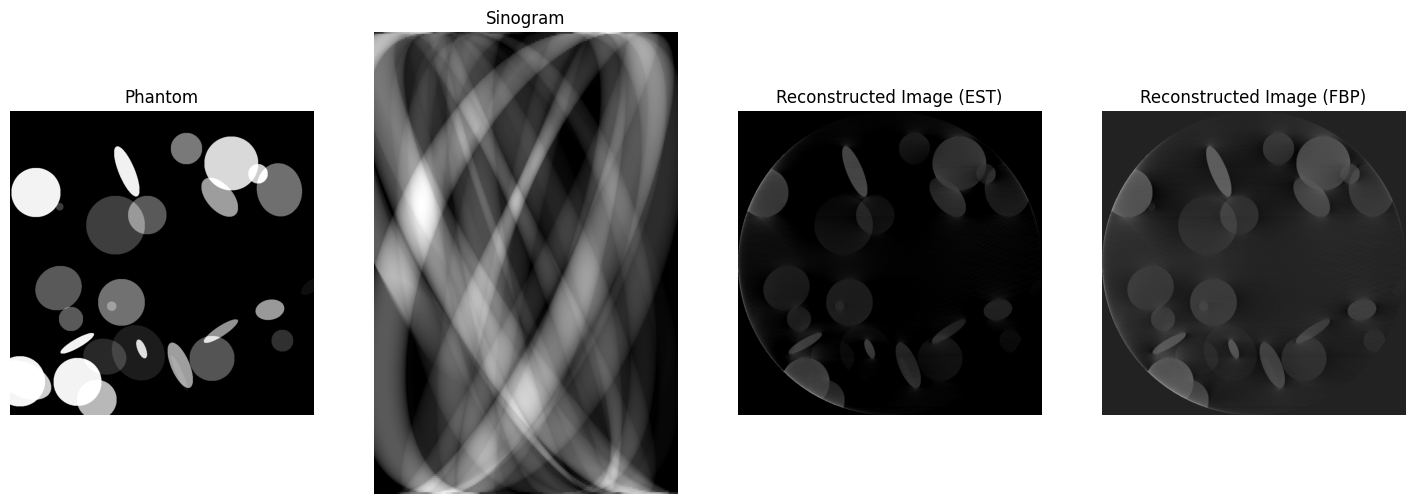

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate as scipy_rotate
from skimage.transform import iradon, radon
from skimage.draw import disk, ellipse  # Import ellipse function from skimage.draw
import cupy as cp

# Function to generate projection angles equally spaced in Fourier space
def EST_Angles(num_projections):
    """
    Generate projection angles that are equally spaced in Fourier space.

    Parameters:
    - num_projections: int, number of projections to generate.

    Returns:
    - theta: 1D array, the projection angles.
    """
    return cp.arcsin(cp.linspace(-1, 1, num_projections)) * 180 / cp.pi

# Function to generate a more complex foam-like phantom with various shapes, intensities, and noise
def make_phantom(size, num_shapes, noise_std=0.05):
    """
    Create a complex phantom with multiple shapes of varying sizes, intensities, and Gaussian noise.

    Parameters:
    - size: int, the size (height and width) of the phantom image.
    - num_shapes: int, the number of shapes to generate.
    - noise_std: float, standard deviation of Gaussian noise to add.

    Returns:
    - phantom: 2D array, the generated phantom image.
    """
    phantom = cp.zeros((size, size), dtype=cp.float32)

    rng = cp.random.default_rng()
    for _ in range(num_shapes):
        shape_type = rng.integers(2)  # 0: disk, 1: ellipse

        if shape_type == 0:
            # Random disk
            x, y = rng.integers(size, size=2)
            radius = rng.integers(5, size // 10)
            intensity = rng.random()

            rr, cc = disk((cp.asnumpy(x), cp.asnumpy(y)), cp.asnumpy(radius), shape=phantom.shape)
            phantom[rr, cc] += intensity
        elif shape_type == 1:
            # Random ellipse
            x, y = rng.integers(size, size=2)
            semiaxis_x = rng.integers(5, size // 10)
            semiaxis_y = rng.integers(5, size // 10)
            angle = rng.random() * 180.0
            intensity = rng.random()

            rr, cc = ellipse(cp.asnumpy(x), cp.asnumpy(y), cp.asnumpy(semiaxis_x), cp.asnumpy(semiaxis_y),
                             rotation=np.deg2rad(cp.asnumpy(angle)), shape=phantom.shape)
            phantom[rr, cc] += intensity

    # Add Gaussian noise
    #noise = rng.normal(loc=0, scale=noise_std, size=(size, size))
    #phantom += noise
    phantom = cp.clip(phantom, 0, 1)  # Ensure intensity stays within [0, 1]

    return cp.asnumpy(phantom)  # Convert CuPy array back to NumPy array for output


# Function to perform Equally Sloped Tomography (EST) reconstruction using CuPy
def EST_reco(sinogram, theta, num_iterations=200, tolerance=1e-5, learning_rate=0.00005):
    num_projections, sx = sinogram.shape
    size = sinogram.shape[1]  # Assuming square image size

    # Initial guess using Filtered Back Projection (FBP)
    initial_guess = iradon(np.rot90(cp.asnumpy(sinogram), -1), theta=cp.asnumpy(theta), circle=True)
    estimated_image = cp.array(initial_guess)

    previous_error = cp.inf

    for iteration in range(num_iterations):
        # Forward projection on GPU using CuPy
        projections = cp.zeros((num_projections, sx), dtype=cp.float32)
        for i, angle in enumerate(theta):
            rotated_image = cp.array(scipy_rotate(cp.asnumpy(estimated_image), angle.get(), reshape=False, order=1, mode='constant', cval=0.0))
            projection = cp.sum(rotated_image, axis=1)
            projections[i, :] = projection

        # Compute error
        error = sinogram - projections
        max_error = cp.max(cp.abs(error))

        print(f"Iteration {iteration + 1}/{num_iterations} - Max error: {max_error.get()}")

        # Early stopping if error change is below the tolerance
        if cp.abs(previous_error - max_error) < tolerance:
            print(f"Convergence reached at iteration {iteration + 1}")
            break

        previous_error = max_error

        # Backproject the error on GPU using CuPy
        backprojected_error = cp.zeros_like(estimated_image, dtype=cp.float32)
        for i, angle in enumerate(theta):
            rotated_error = cp.array(scipy_rotate(cp.asnumpy(error[i, :].reshape(1, -1)), -angle.get(), reshape=False, order=1, mode='constant', cval=0.0))
            backprojected_error += rotated_error

        # Normalize the backprojected error to avoid excessive accumulation
        if cp.max(cp.abs(backprojected_error)) != 0:
            backprojected_error /= cp.max(cp.abs(backprojected_error))

        # Apply gradient descent update
        estimated_image += learning_rate * (backprojected_error / num_projections)
        estimated_image = cp.maximum(estimated_image, 0)  # Apply non-negativity constraint

    return estimated_image.get()  # Convert CuPy array back to NumPy array for output

# Function to create sinogram from phantom image
def make_sino(phantom, theta):
    sinogram = radon(phantom, theta=cp.asnumpy(theta), circle=True)
    return cp.rot90(cp.array(sinogram), 1)

# Example usage
if __name__ == "__main__":
    size = 1024
    num_disks = 30
    phantom = make_phantom(size, num_disks)

    num_projections = 256
    theta = EST_Angles(num_projections)
    sinogram = make_sino(phantom, theta)

    EST_data = EST_reco(sinogram, theta, num_iterations=500, learning_rate=0.0005)
    FBP_data = iradon(np.rot90(cp.asnumpy(sinogram), -1), theta=cp.asnumpy(theta), circle=True)

    # Plot results
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 4, 1)
    plt.title("Phantom")
    plt.imshow(phantom, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.title("Sinogram")
    plt.imshow(cp.asnumpy(sinogram), cmap='gray', aspect='auto')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.title("Reconstructed Image (EST)")
    plt.imshow(EST_data, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.title("Reconstructed Image (FBP)")
    plt.imshow(FBP_data, cmap='gray')
    plt.axis('off')

    plt.show()